In [1]:
from datasets import tdsc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [14]:
dataset = tdsc.TDSC(path_to_dataset="data/tdsc", transformers=[ResizerTransformer(target_size=(256,256))])

In [15]:
x, m, l = dataset[0]
print (x.shape)

(256, 256, 35)


In [16]:
print (np.max(x))
print (np.max(m))

255
1


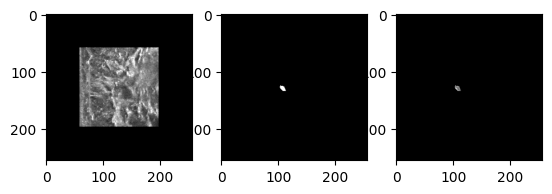

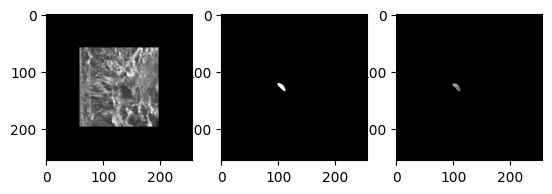

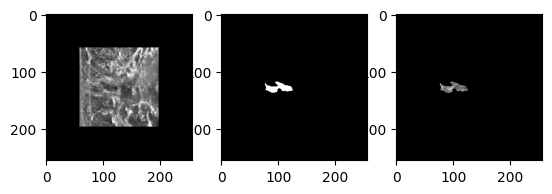

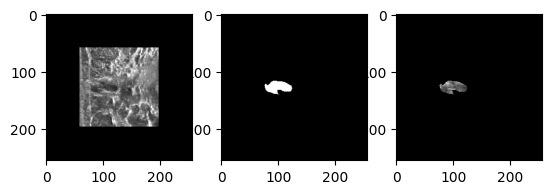

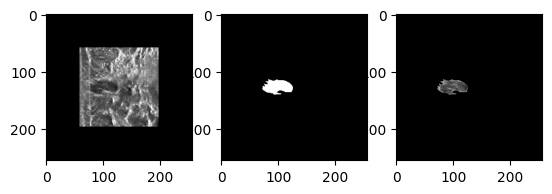

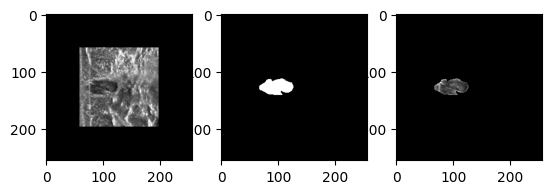

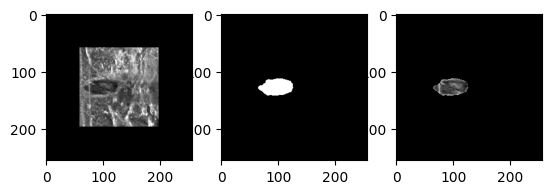

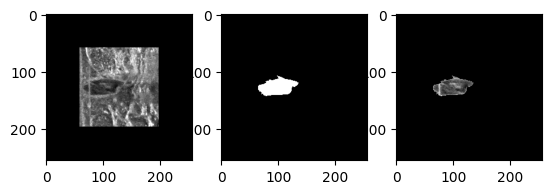

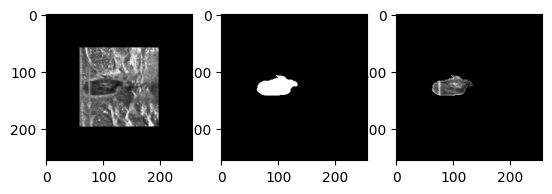

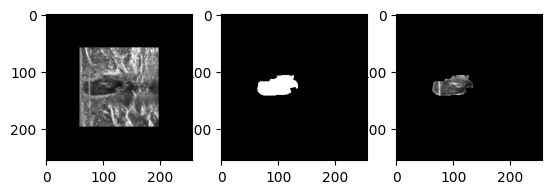

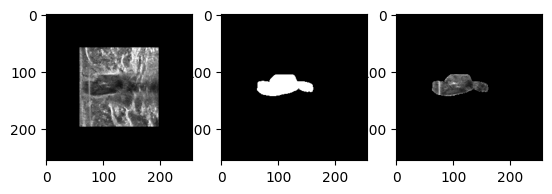

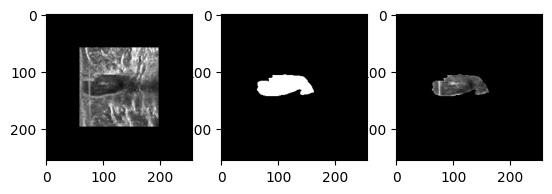

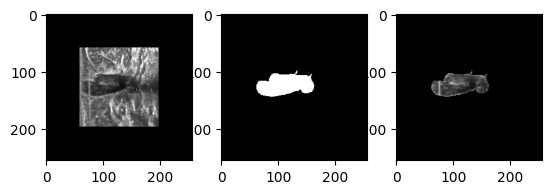

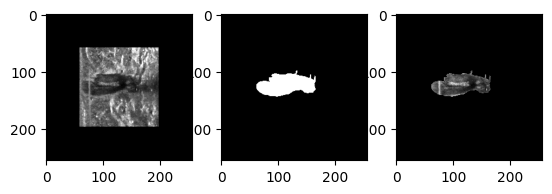

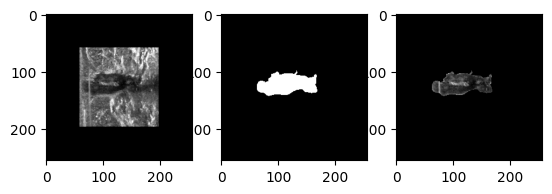

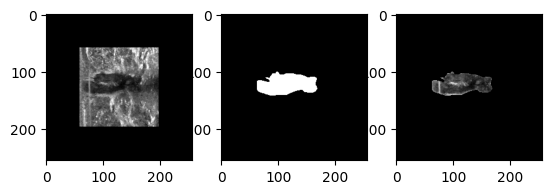

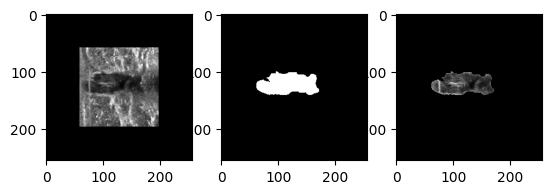

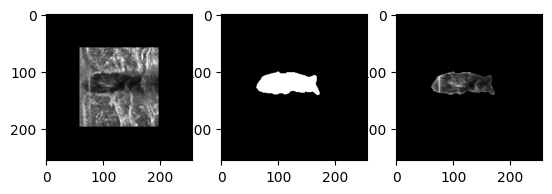

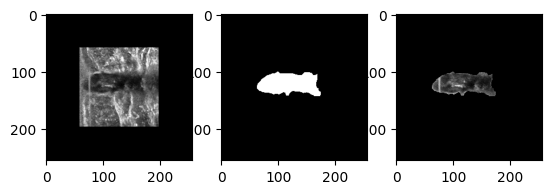

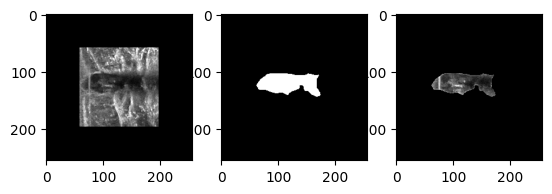

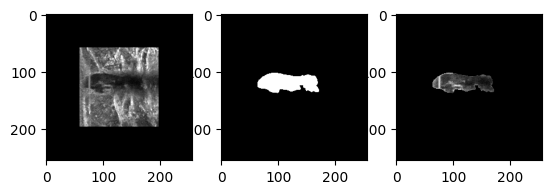

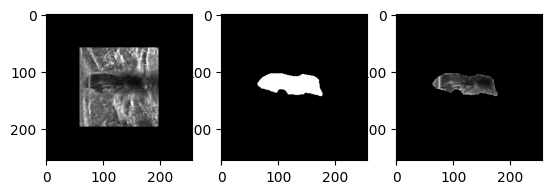

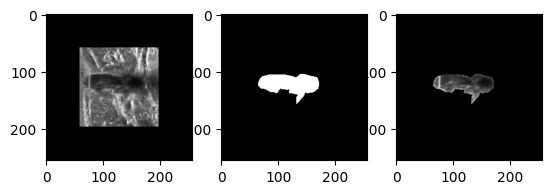

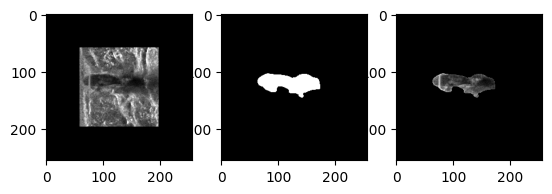

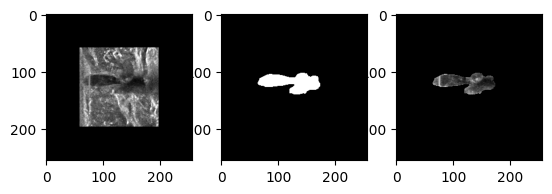

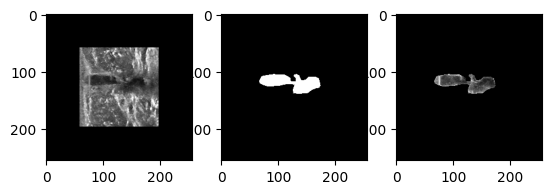

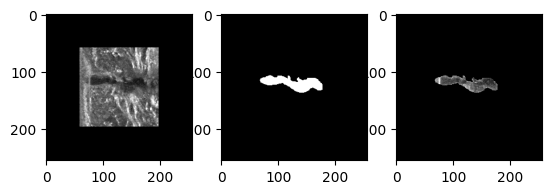

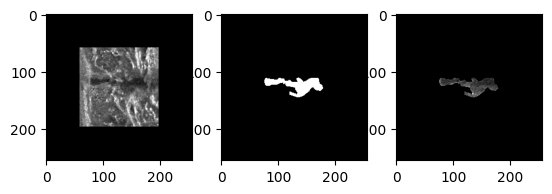

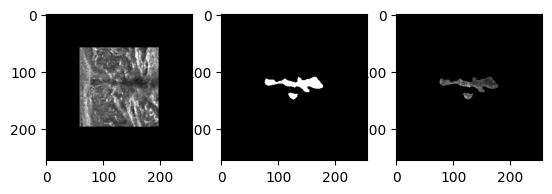

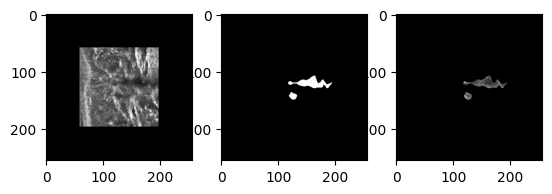

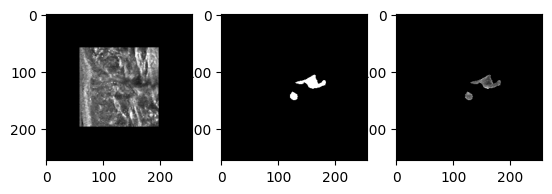

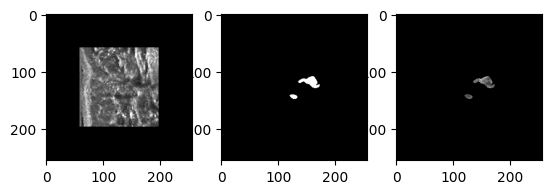

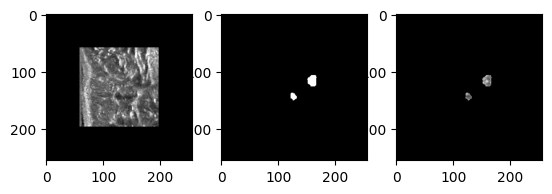

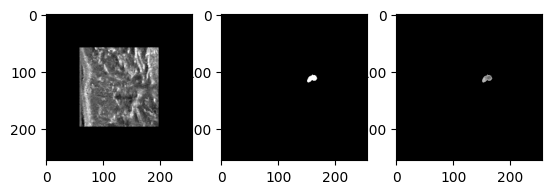

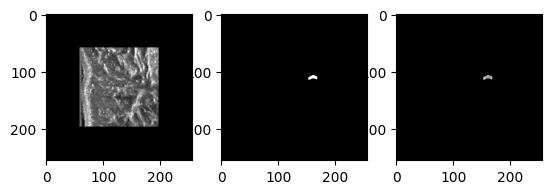

In [17]:
for i in range(x.shape[2]):
    plt.subplot(2,3,1)
    plt.imshow(x[:,:,i], cmap="gray")
    plt.subplot(2,3,2)
    plt.imshow(m[:,:,i]*255, cmap="gray")
    plt.subplot(2,3,3)
    plt.imshow(m[:,:,i]*x[:,:,i], cmap="gray")
    plt.show()

In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Expansive Path
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Contracting Path
        conv1 = self.encoder(x)
        conv2 = self.middle(conv1)
        
        # Expansive Path
        out = self.decoder(conv2)
        
        return out

# Transformers for Normalization, Data augmentation and Resizeing

In [13]:
class Normalizer:
    def __call__(self, sample):
        x, m = sample
        return x/255, m/np.max(m)

class ToTensorTransformer:
    def __call__(self, sample):
        x, m = sample
        return torch.from_numpy(x), torch.from_numpy(m)
    
class ResizerTransformer:
    
    def __init__ (self, target_size):
        self.target_size = target_size
    
    def __call__(self, sample):
        # Get the original image dimensions
        x, m = sample
        
        original_height, original_width, _ = x.shape
        
        # Set the target size
        target_size = (490, 490)

        # Calculate the padding needed
        padding_height = max(0, target_size[0] - original_height)
        padding_width = max(0, target_size[1] - original_width)

        # Calculate the padding amounts for top, bottom, left, and right
        top_padding = padding_height // 2
        bottom_padding = padding_height - top_padding
        left_padding = padding_width // 2
        right_padding = padding_width - left_padding

        # Create a border around the image with zero-padding
        image_with_padding = cv2.copyMakeBorder(
            x,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Set the padding color to black
        )
        
        mask_with_padding = cv2.copyMakeBorder(
            m,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Set the padding color to black
        )

        # Resize the image to the target size (490x490)
        resized_image = cv2.resize(image_with_padding, target_size)
        resized_mask = cv2.resize(mask_with_padding, target_size)
        
        
        resized_image = cv2.resize(image_with_padding, self.target_size)
        resized_mask = cv2.resize(mask_with_padding, self.target_size)
        
        return resized_image, resized_mask

In [22]:
dataset = tdsc.TDSC(path_to_dataset="data/tdsc", transformers=[Normalizer(), ResizerTransformer(target_size=(256,256)), ToTensorTransformer()])
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=2)

In [23]:
# Create the U-Net model
model = UNet(in_channels=1, out_channels=1)  # Input and output channels are both 1 for grayscale images

# Define your U-Net model and other hyperparameters
model = UNet(in_channels=1, out_channels=1)  # Adjust channels based on your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = nn.optim.Adam(model.parameters(), lr=0.001)

# Define your DataLoader for training and validation datasets
train_loader = torch.utDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Training loop
num_epochs = 10


NameError: name 'optim' is not defined

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, masks in train_loader:
        inputs, masks = inputs.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, masks in val_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")

print("Finished Training")